In [6]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


# Pytorchifying the code :) and using the normalization layers

# Using these layers makes our toch less brittle to changes in the gain

# forward and backward pass will be hte same but update is still slightly affected - ?how it updates across t
# ? ISNT IT JUST THAT THE WEIGHTS ARE NOW SMALLER TO BEGIN WITH BECAUSE THE GAIN IS LESS

# May have to return learning rate

# code from last time

In [1]:
# read in all the wrods
words = open("makemore/names.txt", "r").read().splitlines()
len(words)

32033

In [2]:
#build the vocabulary of characters and ampping tofrom integers
chars = sorted(list(set("".join(words))))
stoi = {s:i for i,s in enumerate(["."] +chars)}
itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi.items())


In [7]:
#build the dataset
# build the dataset
def build_dataset(words):
    block_size = 3 # how many chars do we take to predict the next one (context length)
    X, Y = [], []

    for w in words[:]:
        #print(w)
        context = [0]*block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print("".join(itos[i] for i in context),"-->",itos[ix])
            context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    X.shape, Y.shape
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])



In [24]:
# Let's train and deeper Neural network

class Linear:
    
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in,fan_out)) * 1/(fan_in ** 0.5) #should technically a unifomr dist
        #self.weight = torch.zeros((fan_in,fan_out)) * 1/(fan_in ** 0.5) #change to zero and check how it trains
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias

        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias]) #[] adds nothing which [None] adds a none object
    
class BatchNorm1d:

    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True #pytroch nn modules have this attribute allow us to make hte module have a different behaviour in trianing vs evaluation 
        
        #parameters (trained with backprop)
        self.gamma  = torch.ones(dim) #bngain
        self.beta = torch.zeros(dim) #gnbias

        #buffers (trainig ith a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self,x):
        #calcualte forward pass
        #want to normalize across the rows of x

        if self.training == True:
            xmean = x.mean(dim = 0, keepdim = True)
            xvar = x.var(dim = 0, keepdim = True)
        else:
            xmean = self.running_mean
            xvar = self.running_std

        #normalize layer
        xhat =  (x - xmean) / (xvar + self.eps)**0.5 
        self.out = self.gamma * xhat + self.beta

        #update buffers
        if self.training:
            with torch.no_grad(): #context manager for efficiency :)
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar

        #return output
        return self.out #pytorch does not do a self.out - done to allow some inference, just retur d

    def parameters(self):
        return [self.gamma, self.beta]
    


class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []


In [26]:
n_embd = 10
block_size = 3
n_hidden = 200
g = torch.Generator().manual_seed(2147483547)

C = torch.randn((vocab_size, n_embd))

layers = [
    Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    #make last layer less confidence
    layers[-1].weight *= 0.1

    # #all other layers apply gain of tanh
    # for layer in layers[:-1]:
    #     if isinstance(layer, Linear):
    #         layer.weight *= 5/3 #change this to 1 and then run the activation visualization funciton - CRAZY
    #         #makes so much sense - if linear layers no need out 1/sqrt(n would control)
    #         # but tanh is a squashing funciton so it will decrease the std and thus we need to add a gain to correct for this
    #         # thie gain must be depended on the input being standard normal - as teh amount of sqaushing would depedn on input to tanh
    #         #5/3 is a bit of a magic number hahaha

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


12097


In [32]:
#same optimization as last time....
max_steps = 200000
batch_size = 32
lossi = []
ud = [] #update to data ratio

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g) #random sample of indexes
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    #backward pass
    for layer in layers:
        layer.out.retain_grad() #AFTER_DEBUG: would take out retain graph
    for p in parameters:
        p.grad = None
    loss.backward() 

    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().mean() for p in parameters])
    
    # if i > 1000:
    #     break #AFTER_DEBUG obviuoslt take this out


      0/ 200000: 2.6009
  10000/ 200000: 2.1566
  20000/ 200000: 2.2495
  30000/ 200000: 1.9550


# **Network debug**

layer 2 (      Tanh): mean +0.00, std 0.64, saturated 3.20


Text(0.5, 1.0, 'activation distribution')

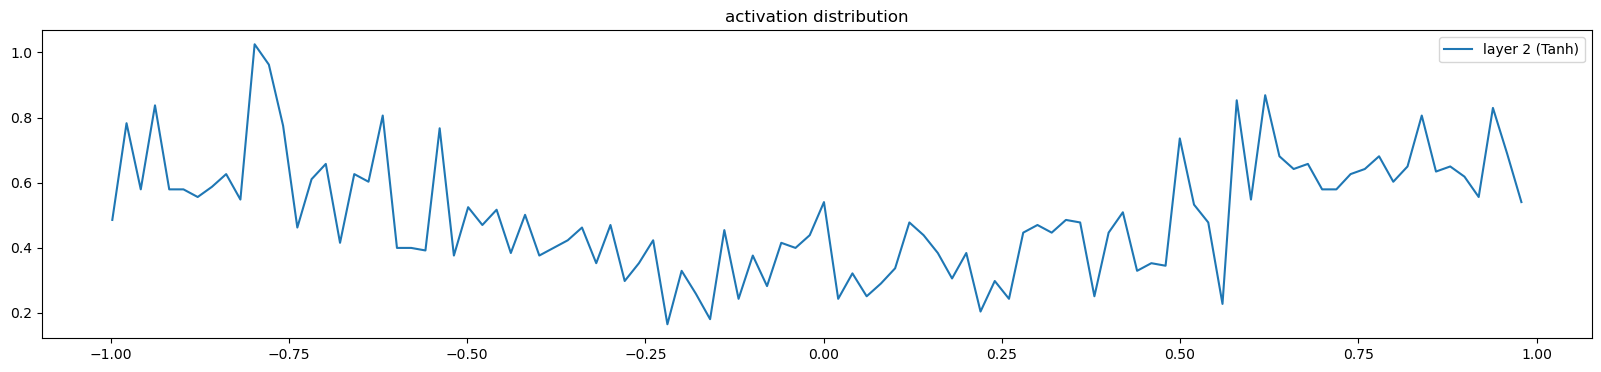

In [28]:
#visualize historgrams of foward pass activations
plt.figure(figsize = (20,4))
legends = []
for i,layer in enumerate(layers[:-1]): #exclude output layer
    if isinstance(layer,Tanh):
        t = layer.out #this is why we need this
        print("layer %d (%10s): mean %+.2f, std %.2f, saturated %.2f" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100 ))
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title("activation distribution")

#stabilizes as we add the gain term
# if we do not put it the std shrinks adn the saturation also going to zero

layer 2 (      Tanh): mean -0.000065, std 1.782548e-03


Text(0.5, 1.0, 'gradient distribution')

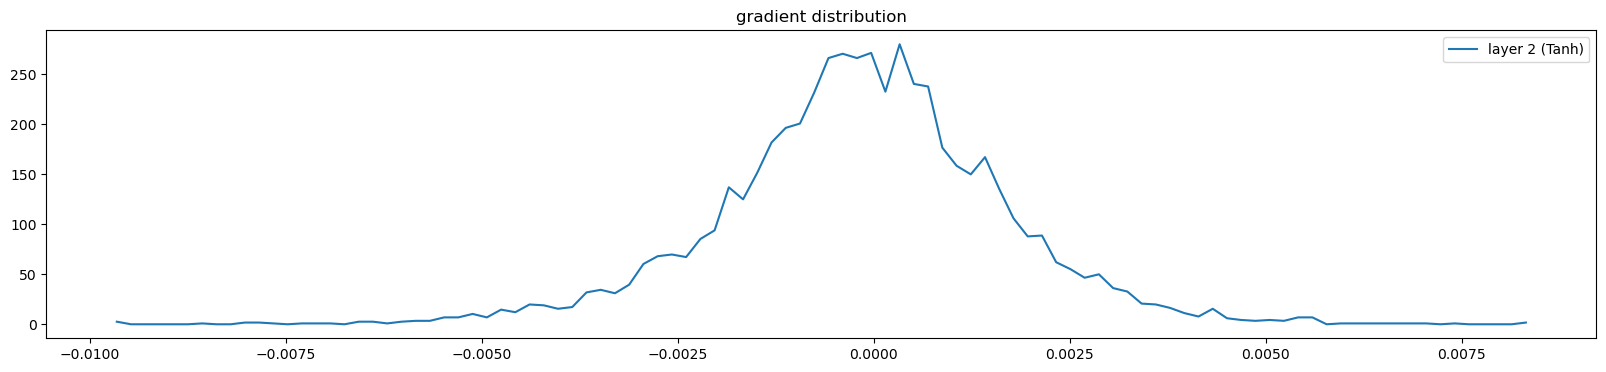

In [29]:
#visualize historgrams of gradients activations
plt.figure(figsize = (20,4))
legends = []
for i,layer in enumerate(layers[:-1]): #exclude output layer
    if isinstance(layer,Tanh):
        t = layer.out.grad #this is why we need this
        print("layer %d (%10s): mean %+f, std %e" % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title("gradient distribution")

#stabilizes as we add the gain term
# if we do not put it the std shrinks adn the saturation also going to zero

weight   (27, 10) | mean -0.000000 | std 9.157771e-03 | grad:data ratio 9.145946e-03
weight  (30, 200) | mean +0.000112 | std 7.799477e-03 | grad:data ratio 4.249698e-02
weight  (200, 27) | mean +0.000000 | std 1.920921e-02 | grad:data ratio 3.622825e-01


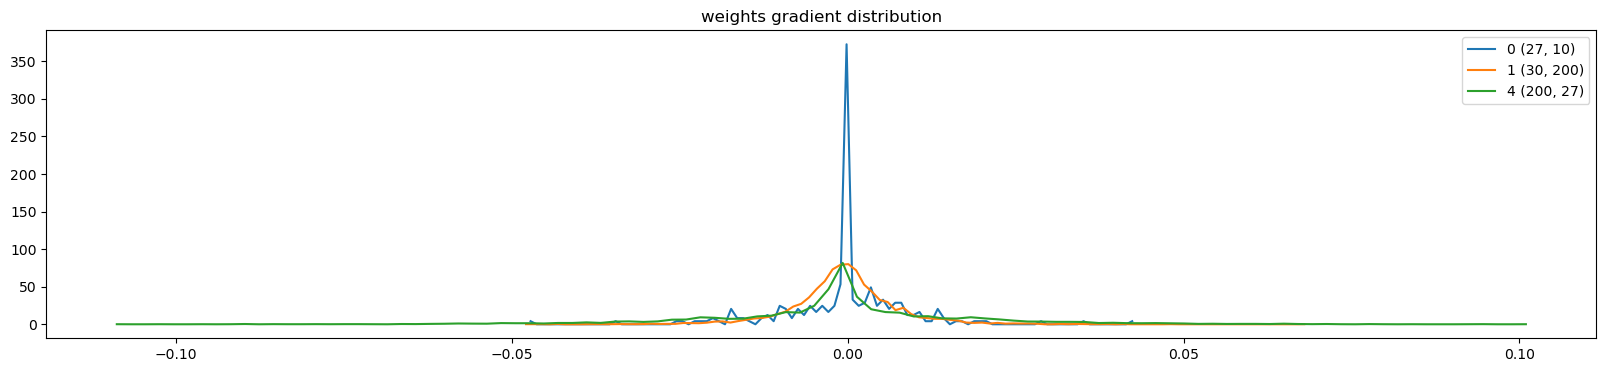

In [30]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad #gradient of the parameters
  p #the parameters themselves
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

# grad:data rtaio
#Size of gradietn compared to size of parameter weights - want to take small steps .data vs .grad
# not true in last layer - whose gradients are 10x greater than all the other weights
# last layers is trained 10x faster
# Fixes itself if you train for a bit longer 

This stabilizes a bit after some trianing

Also not that activations saturate a little but remain stable
And gradients are also stable

## Gradient to data is not as relevant as update to data ratio#

## the below plot will reveal if hte learning rate is too slow

# we want to be around 1e-3 update should be 1/1000 of the data

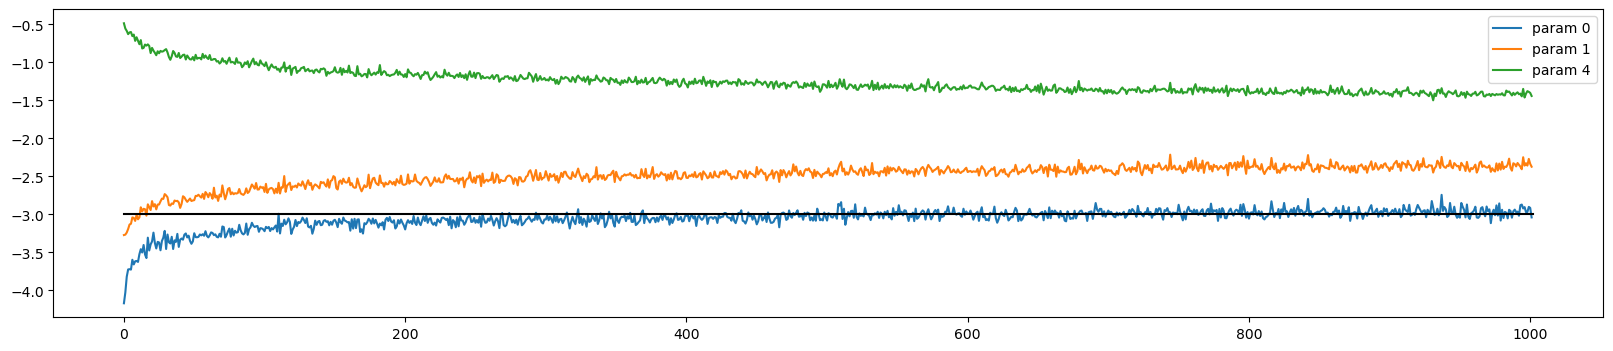

In [31]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

# E01

Set all weights and biases to 0 and check how it trains

They stabilize during training , rough guide is should be ~ -3

Final layer is an outlier as we artificially strunk hte data to keep hte shoftmax from ebing too confidence - so grad/data will be larger

OLD STUFF

In [ ]:
# create GIF
#creating plot
with imageio.get_writer("test2.gif",mode = "i") as writer: #get_writer creates a new file "line.gif" and mode simply tells it we are giving it images as an input
    for i in [100,1000,2000,3000,4000,5000,6000,7000,8000,9000] + list(np.arange(10000,max_steps,10000)):
        image = imageio.v2.imread(f"plots/epoch_{i}.png"); #read image
        writer.append_data(image) #writes to the file specified above

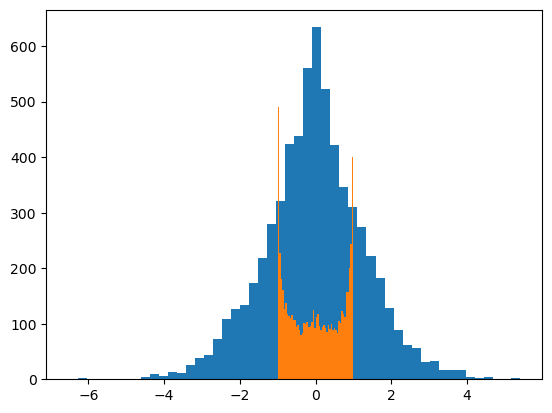

In [ ]:
# # check tanh values after initialization
plt.hist(hpreact.view(-1).tolist(),bins = 50); #semi colon suppreses text
plt.hist(h.view(-1).tolist(),bins = 50); #semi colon suppreses text

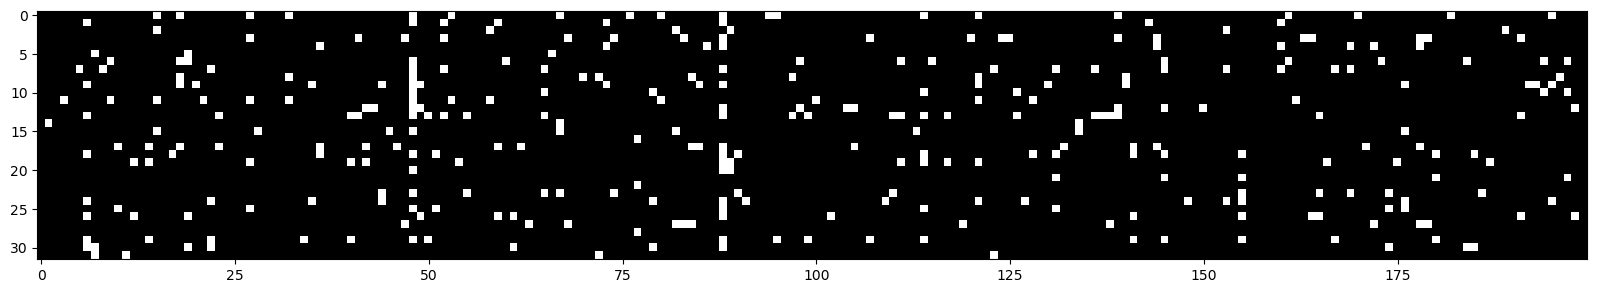

In [ ]:
plt.figure(figsize = (20,10))
plt.imshow(h.abs() > 0.99, cmap = "gray",interpolation = "nearest")
#if white = in a flat region
# if for one of these neurons every column is white - this is called a dead neuron
# neuron is not sensitive to any of hte inputs -all enurons go to 0
# will be stuck

In [ ]:
#{"test":[1,2,3]}["test"]

In [ ]:
#sample from modle
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size #initialize
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0],-1) # concat onto (N, block_size * n_emb)
        h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)
        counts = logits.exp()
        prob = F.softmax(logits, dim = 1) 
        ix = torch.multinomial(prob, num_samples = 1, generator = g).item()

        #shift context windown
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print("".join(itos[i] for i in out))

brbabgghanzshevfedhny.
luqmivrslejghnngtodcepprellizslipselleksisssopparlellbcottalpin.
shdwnngxhdminstyn.
joxtdviqxettalfius.
kaddi.
kyldslyehs.
klajndsklyah.
hbldsadyansuftzgahliqubrdtchmpksvikostzpsh.
brftyxoeshangphir.
sumtez.
shhmeernnisssorgelverdwvllanictarvizthphrshlvislitgfedvallivid.
mellaketbuklypxanntud.
jshiv.
kgyannclaudrifwandillvislquijahnnahmniftlfptta.
kimbegloveetgannnbek.
klporyinstzvabrrtzw.
shkmambertbncarldvettw.
francellamryzdelbeel.
fclylbs.
bbightanqusfarrllluxpdngtoportco.


# fixing up this old code
# 1. Initialization 
- if predicting uniform 1/27 change of being right so loss will be 
-log(1/27) =~ 3.3, however our starting loss is 27! - becuase we initialize with normal dist centered on 0
?Network is very confidently wrong occasionally - makes softamx have very low prob for the real answer
- more extreme values for logits - higer loss (as unlikely by chance to assign the highest prob to the true value, more likely that high value is for another output and this squashes the prob of the true value when doing softmax)
We want initial output to be a uniform probability distribution

### so how to we make logits closer to 0 - ideal becuase of symmetry (rather than all being 1)
a. Initialize bias as 0 
b. scalle weights lower - **BUT NOT 0**
    Need loss to have some entropy - used for symmetry breaking

lose hockey stick appearance of loss


# 2. Activation of hidden states (Saturated tanh)

Initial activation of hidden layer - lots of -1's and 1's

We have tanhed - this region of hte tanh is very flat - we are on the tail
 - so gradients will be small 
Will "kill" the backprogogation through this neuron, will take very small steps
Remember "Gradient" descent - gradient vanishe

dtanh/dx = 1 - tanh**2 

For tanh when output = 0, grad = 1 so backprob gradient just flows through, so the more away from 0 you are the less hte graient will flow

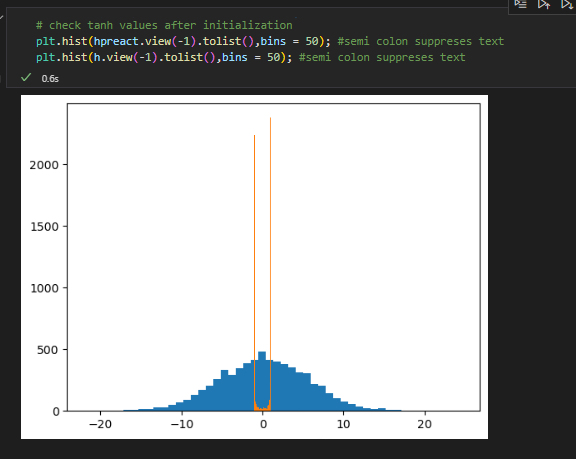

all squashing activation functions will have this issue
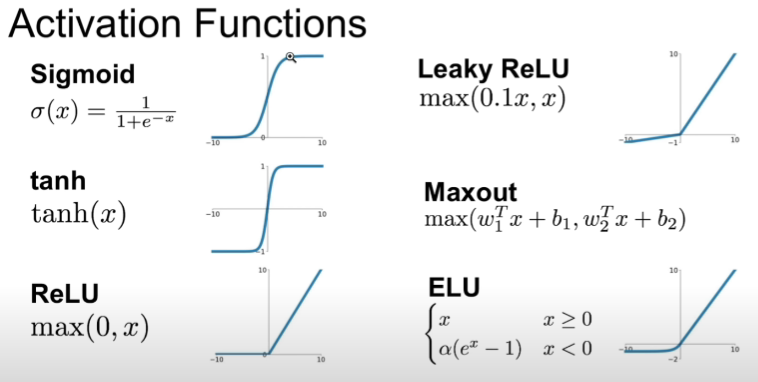

ReLU is dead below 0 - can start dead or if your learning rate is too high it can jump into the dead region ("knocked out of the data manifold")
    *Note that over hte course of training, neurons will naturally become saturated

Like brain damage in the neural network

*tip is that your fully train a ReLU network then you forward pass to find a dead neurons

Leaky ReLU is designed to cope with this issue 


Easiest way to cope with this - shrink the param 

This is easy for a smal l netwrok
But these problems stack so can be a real issue for larger networks.

# BUT HOW DO WE FIND A GOOD INITIALIZATION







tensor(-0.0072) tensor(0.9984)
tensor(0.0035) tensor(1.0003)


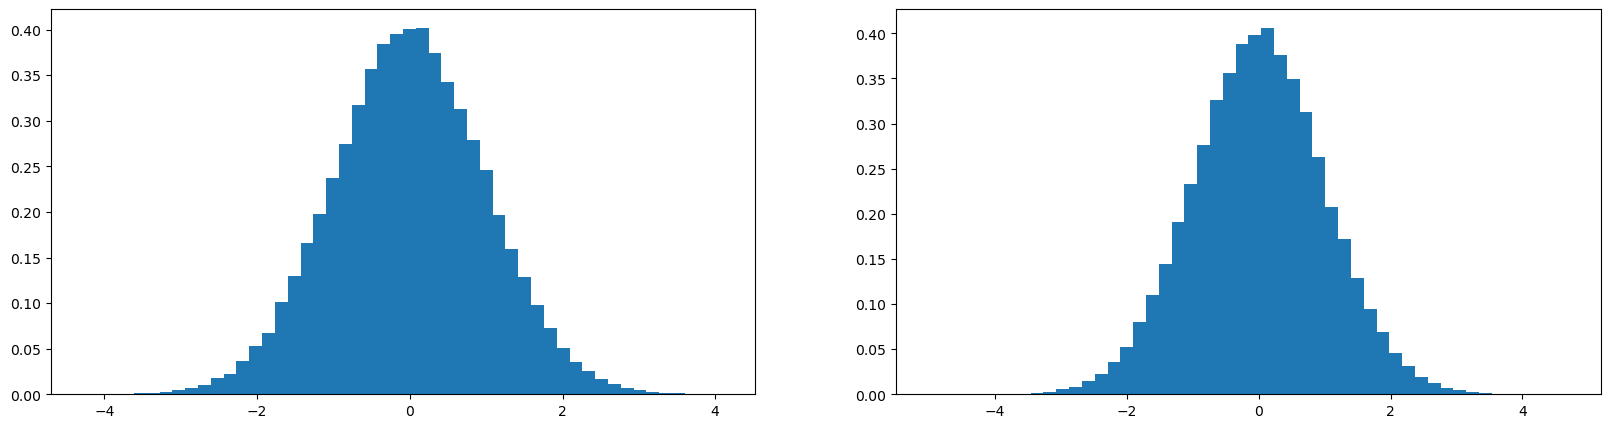

In [ ]:
# some prefacing explanation on variance changes after matrix multiplication of gausians

#mean stays the same as it is a symmetric operation
#however standard deviation has increased

#we dont want this
# we ant uint gaussian throughtout the neural net

#how do we scale this?
#what number do we scale w by to make y have a unit standard 

#try matrix of size 10,100 and 1000 
n = 100
x = torch.randn(1000,n)
w = torch.randn(n,100) / n**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize = (20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density = True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density= True);

x = unit_normal
E[x] = 0
Variance = 1 = E[x**2] - E[x]**2
Variance = 1 so E[x**2] = 1

w = unit_normal

if independent 
E[xy] = E[x]*E[y]

Var[xy] = E[x**2 * y **2] - E[xy]**2
Var[xy] = E[x**2] * E[y**2] = 1

BUT WHEN MATRIX MULTIPLYING THIS DOESNT HOLD.... as we also have addition from the dot product

$
E[x + y] = E[x] + E[y] = 0 + 0 = 0 \\
Var[x + y] = E[x**2 + 2xy + y**2] - E[x + y]**2 \\
Var[x + y] = E[x**2] + 2E[xy] + E[y**2] - 0
Var[x + y] = 1 + 2(E[x]*E[y]) + 1
Var[x + y] = 1 + 2*0 + 1 = 2
$

Var scaled linearly with number of units so std scales sqrt

so need to scale matrix by....

# $ \dfrac{1}{\sqrt{n}} $

# where n = "fanin"

# but ReLU squashes away half of the code so need to compensate for this with doublign the gain to get 

# $ \dfrac{2}{\sqrt{n}} $

can do this in pytorch

# torch.nn.init.kaiming_normal_()

karpathy just goes 1/sqrt(n)

In [ ]:
x = np.random.normal(0,1,1000)
w = np.random.normal(0,1,1000)
print(f"x, mean:{x.mean():.4f} w, mean: {w.mean():.4f}")
print(f"x*y mean:{(x*w).mean()} var:{(x*w).var()}")
print(f"x + y mean:{(x+w).mean()} var:{(x+w).var()}")


x, mean:-0.0046 w, mean: -0.0273
x*y mean:0.015024171569376342 var:0.8875741201763758
x + y mean:-0.03192193138255582 var:1.9916558249447103


# **Batch normalization**

We want preactivation states to be roughly unit gaussian at initialization

### So why not just normalize them to be gaussian

standardizing hiddens states is a perfectly differentiable operation :)

So do batch normalization

But we dont want them to stay standard normal 

# tested this and loss was a 3.5 for train and test - sike i made an error - loss is fine across this small netwrok but would make a difference in larger networks

so can just add scale and shift terms which the network can learn

Interesting

Basically impossible to tune scales so that all activations are roughlly gasussian 

So we sprinkle batch normalization layers throughout the NN

## **Batch noramlization after every linear layer - wowowwow**

Significantly stabilizes trainig

# But comes at a terrible cose

Previously...

single input feeds into a neural net which creates activations and finally its logits and this is deterministic process

Batches introduced for efficiency

But now Batches influence the forward pass of each input
## So now the activations are a function of all the other inputs in the batch

# ##BLACK MAGIC##

THIS IS ACTUALLY GOOD - acts as a regularizer - inputs entropy

a form of data augmentation

Makes it harder to neural net to ovefit the examples

# No-one likes this property to prevent coupling so people have tried to depricate this

Alternatives:
1. Linear 
2. Instance
3. Group


How do we sample from a NN with normalized layers??

